In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import MetaTrader5 as mt5

In [2]:
def f_init_login(param_acc, param_pass, param_exe):
    """
    Initialize conexion and Login into a Meta Trader 5 account in the local computer where this code is executed, using the MetaTrader5 python package.
    Parameters
    ----------
    param_acc: int
        accout number used to login into MetaTrader5 Web/Desktop App (normally is a 8-9 digit integer number)
        param_acc = 41668916
    param_pass: str
        accout trader's password (or just password) to login into MetaTrader5 Web/Desktop App 
        (normally alphanumeric include uppercase and sometimes symbols). If the investor's password 
        is provided, the some actions do not work like open trades.
        param_pass = "n2eunlnt"
    
    param_direxe: str
        Route in disk where is the executable file of the MetaTrader5 desktop app which will be used 
        param_direxe = 'C:\\Program Files\\MetaTrader 5\\terminal64.exe'
    
    Return
    ------
        if connection is succesful then returns connected client object and prints message,
        if connection is not succesful then returns error message and attempts a shutdown of connection.
    
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5login_py
    
    
    """
    
    # server name (as it is specified in the terminal)
    mt5_ser = "FxPro-MT5"
    # timeout (in miliseconds)
    mt5_tmo = 10000

    # Perform initialization handshake
    ini_message = mt5.initialize(param_exe, login=param_acc, password=param_pass, server=mt5_ser,
                                 timeout=mt5_tmo, portable=False)

    # resulting message
    if not ini_message:
        print(" **** init_login failed, error code =", mt5.last_error())
        mt5.shutdown()
    else: 
        print(" ++++ init_login succeded, message = ", ini_message)
    
    # returns an instance of a connection object (or client)
    return mt5

In [3]:
def f_acc_info(param_ct):
    """
    Get the info of the account associated with the initialized client param_ct
    Params
    ------
    param_ct: MetaTrader5 initialized client object
        this is an already succesfully initialized conexion object to MetaTrader5 Desktop App
    Returns
    -------
    df_acc_info: pd.DataFrame 
        Pandas DataFrame with the account info         
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5login_py
    """

    # get the account info and transform it into a dataframe format
    acc_info = param_ct.account_info()._asdict()
    
    # select especific info to display
    df_acc_info = pd.DataFrame(list(acc_info.items()), columns=['property','value'])

    # return dataframe with the account info
    return df_acc_info

In [4]:
def f_hist_trades(param_ct, param_ini, param_end):
    """
    Get the historical executed trades in the account associated with the initialized MetaTrader5 client
    Params
    ------
    param_ct: MetaTrader5 initialized client object
        This is an already succesfully initialized conexion object to MetaTrader5 Desktop App
    
    param_ini: datetime
        Initial date to draw the historical trades
        
        param_ini = datetime(2021, 2, 1)
    param_end: datetime
        Final date to draw the historical trades
        
        param_end = datetime(2021, 3, 1)
    Returns
    -------
        df_hist_trades: pd.DataFrame
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5historydealsget_py
    https://www.mql5.com/en/docs/constants/tradingconstants/dealproperties  
    
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5historyordersget_py
    https://www.mql5.com/en/docs/constants/tradingconstants/orderproperties#enum_order_property_integer
    """

    # get historical info of deals in the account
    history_deals = param_ct.history_deals_get(param_ini, param_end)

    # get historical info of orders in the account
    history_orders = param_ct.history_orders_get(param_ini, param_end)

    # check for returned results
    if (len(history_orders) > 0) & (len(history_deals) > 0):
        print(" ++++ Historical orders retrive: OK")
        print(" ++++ Historical deals retrive: OK")
    else:
        print("No orders and/or deals returned")

    # historical deals of the account
    df_deals = pd.DataFrame(list(history_deals), columns=history_deals[0]._asdict().keys())
    
    # historical orders of the account
    df_orders = pd.DataFrame(list(history_orders), columns=history_orders[0]._asdict().keys())
   
    # useful columns from orders
    df_hist_trades = df_orders[['time_setup', 'symbol', 'position_id', 'type', 'volume_current',
                           'price_open', 'sl', 'tp']]

    # rename columns 
    df_hist_trades.columns = ['OpenTime', 'Symbol', 'Ticket', 'Type', 'Volume', 'OpenPrice', 'S/L', 'T/P']

    # choose only buy or sell transactions (ignore all the rest, like balance ...)
    df_hist_trades = df_hist_trades[(df_hist_trades['Type'] == 0) | (df_hist_trades['Type'] == 1)]
    df_hist_trades['OpenTime'] = pd.to_datetime(df_hist_trades['OpenTime'], unit='s')
    
    # unique values for position_id
    uni_id = df_hist_trades['Ticket'].unique()
    
    # first and last index for every unique value of position_id
    ind_opens = [df_hist_trades.index[df_hist_trades['Ticket'] == i][0] for i in uni_id]
    ind_closes = [df_hist_trades.index[df_hist_trades['Ticket'] == i][-1] for i in uni_id]
    
    # generate lists with values to add
    cts = df_hist_trades['OpenTime'].loc[ind_closes]
    cps = df_hist_trades['OpenPrice'].loc[ind_closes]

    # resize dataframe to have only the first value of every unique position_id
    df_hist_trades = df_hist_trades.loc[ind_opens]

    # add close time and close price as a column to dataframe
    df_hist_trades['CloseTime'] = cts.to_list()
    df_hist_trades['ClosePrice'] = cps.to_list()
    df_hist_trades['Profit'] = df_deals['profit'].loc[df_deals['position_id'].isin(uni_id) & 
                                                      df_deals['entry'] == 1].to_list()
  
    return df_hist_trades

In [5]:
def f_hist_prices(param_ct, param_sym, param_tf, param_ini, param_end):
    """
    Historical prices retrival from MetaTrader 5 Desktop App.
    Parameters
    ----------
    param_ct: MetaTrader5 initialized client object
        This is an already succesfully initialized conexion object to MetaTrader5 Desktop App
      
    param_sym: str
        The symbol of which the historical prices will be retrieved
        
        param_sym = 'EURUSD'
    
    param_tf: str
        The price granularity for the historical prices. Check available timeframes and nomenclatures from 
        the references. The substring 'TIMEFRAME_' is automatically added.
        
        param_tf = 'M1'
    param_ini: datetime
        Initial date to draw the historical trades
        
        param_ini = datetime(2021, 2, 1)
    param_end: datetime
        Final date to draw the historical trades
        
        param_end = datetime(2021, 3, 1)
    
    **** WARNINGS ****
    
    1.- Available History
    
        MetaTrader 5 terminal provides bars only within a history available to a user on charts. The number of # bars available to users is set in the "Max.bars in chart" parameter. So this must be done
        manually within the desktop app to which the connection is made.
    
    2.- TimeZone
        When creating the 'datetime' object, Python uses the local time zone, 
        MetaTrader 5 stores tick and bar open time in UTC time zone (without the shift).
        Data received from the MetaTrader 5 terminal has UTC time.
        Perform a validation whether if its necessary to shift time to local timezone.
    **** ******** ****
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5copyratesfrom_py#timeframe
    """


    # get hour info in UTC timezone (also GMT+0)
    hour_utc = datetime.datetime.now().utcnow().hour
    # get hour info in local timezone (your computer)
    hour_here = datetime.datetime.now().hour
    # difference (in hours) from UTC timezone
    diff_here_utc = hour_utc - hour_here
    # store the difference in hours
    tdelta = datetime.timedelta(hours=diff_here_utc)
    # granularity 
    param_tf = getattr(param_ct, 'TIMEFRAME_' + param_tf)
    # dictionary for more than 1 symbol to retrieve prices
    d_prices = {}

    # retrieve prices for every symbol in the list
    for symbol in param_sym:
        # prices retrival from MetaTrader 5 Desktop App
        prices = pd.DataFrame(param_ct.copy_rates_range(symbol, param_tf,
                                                         param_ini - tdelta,
                                                         param_end - tdelta))
        # convert to datetime 
        prices['time'] = [datetime.datetime.fromtimestamp(times) for times in prices['time']]

        # store in dict with symbol as a key
        d_prices[symbol] = prices
    
    # return historical prices
    return d_prices

In [10]:
# local direction of executable file
local_exe = 'C:\\Program Files\\MetaTrader 5\\terminal64.exe'

# account number *** USE YOURS INSTEAD ***
mt5_acc = 5387245

# account Password Traders/Investors *** USE YOURS INSTEAD ***
# mt5_trd_pas = "n2eunlnt" 
mt5_inv_pas = "7qjzgtWX"

# try initialization and login
mt5_client = f_init_login(param_acc=mt5_acc, param_pass=mt5_inv_pas, param_exe=local_exe)

 ++++ init_login succeded, message =  True


In [11]:
df_acc_info = f_acc_info(param_ct=mt5_client)

In [16]:
ini_date = datetime.datetime(2021, 6, 29, 0, 0)
end_date = datetime.datetime(2021, 7, 2, 0, 0)

# get historical prices
df_hist = f_hist_trades(param_ct=mt5_client, param_ini=ini_date, param_end=end_date)

 ++++ Historical orders retrive: OK
 ++++ Historical deals retrive: OK


In [17]:
df_hist

OpenTime  Symbol    Ticket  Type  Volume  OpenPrice  S/L  T/P  \
0 2021-07-01 21:26:03  EURUSD  43355093     0     0.0        0.0  0.0  0.0   

            CloseTime  ClosePrice  Profit  
0 2021-07-01 21:26:12         0.0   -0.15

In [18]:
import json

In [191]:
ini_date = df_hist['OpenTime'].iloc[0] - datetime.timedelta(minutes=76288)
# construct init time from the OpenTime + minute of the last trade
end_date = df_hist['CloseTime'].iloc[-1] + datetime.timedelta(minutes=1)
# get all the symbols traded in order to download prices for all of them
symbols = list(df_hist['Symbol'].unique())

# get historical prices using UTC time
df_prices = f_hist_prices(param_ct=mt5_client, param_sym=symbols, param_tf='M15',
                             param_ini=ini_date, param_end=end_date)

In [192]:
data=df_prices['EURUSD']
#data=data[:12]
data

time     open     high      low    close  tick_volume  \
0    2021-05-09 19:00:00  1.21599  1.21707  1.21599  1.21659          546   
1    2021-05-09 19:15:00  1.21659  1.21667  1.21654  1.21663          379   
2    2021-05-09 19:30:00  1.21663  1.21663  1.21654  1.21657          278   
3    2021-05-09 19:45:00  1.21657  1.21663  1.21613  1.21661          370   
4    2021-05-09 20:00:00  1.21661  1.21728  1.21653  1.21725         3970   
5    2021-05-09 20:15:00  1.21725  1.21740  1.21627  1.21627         3302   
6    2021-05-09 20:30:00  1.21627  1.21639  1.21606  1.21628         2949   
7    2021-05-09 20:45:00  1.21628  1.21669  1.21626  1.21668         1794   
8    2021-05-09 21:00:00  1.21668  1.21724  1.21668  1.21714         3322   
9    2021-05-09 21:15:00  1.21714  1.21728  1.21698  1.21718         2660   
10   2021-05-09 21:30:00  1.21718  1.21744  1.21705  1.21738         3133   
11   2021-05-09 21:45:00  1.21737  1.21761  1.21699  1.21699         4468   
12   2021-05-09 22:00:00  1.21699  1.21700  1.21622  1.21652         8702   
13   2021-05-09 22:15:00  1.21652  1.21672  1.21606  1.21625         7208   
14   2021-05-09 22:30:00  1.21625  1.21645  1.21592  1.21605         6614   
15   2021-05-09 22:45:00  1.21606  1.21635  1.21594  1.21608         7308   
16   2021-05-09 23:00:00  1.21608  1.21625  1.21584  1.21622         9051   
17   2021-05-09 23:15:00  1.21622  1.21624  1.21552  1.21562         8973   
18   2021-05-09 23:30:00  1.21562  1.21583  1.21538  1.21583         8795   
19   2021-05-09 23:45:00  1.21583  1.21592  1.21552  1.21574         7303   
20   2021-05-10 00:00:00  1.21574  1.21602  1.21573  1.21574         6977   
21   2021-05-10 00:15:00  1.21574  1.21577  1.21523  1.21527         6962   
22   2021-05-10 00:30:00  1.21527  1.21552  1.21523  1.21539         6432   
23   2021-05-10 00:45:00  1.21539  1.21541  1.21506  1.21508         6085   
24   2021-05-10 01:00:00  1.21508  1.21523  1.21504  1.21516         5277   
25   2021-05-10 01:15:00  1.21516  1.21554  1.21514  1.21552         5551   
26   2021-05-10 01:30:00  1.21552  1.21558  1.21543  1.21546         5540   
27   2021-05-10 01:45:00  1.21546  1.21546  1.21532  1.21541         4065   
28   2021-05-10 02:00:00  1.21541  1.21552  1.21525  1.21544         4451   
29   2021-05-10 02:15:00  1.21544  1.21556  1.21534  1.21546         3640   
30   2021-05-10 02:30:00  1.21546  1.21560  1.21540  1.21554         3857   
31   2021-05-10 02:45:00  1.21554  1.21566  1.21507  1.21508         5016   
32   2021-05-10 03:00:00  1.21508  1.21564  1.21508  1.21563         5229   
33   2021-05-10 03:15:00  1.21563  1.21568  1.21531  1.21556         5175   
34   2021-05-10 03:30:00  1.21556  1.21587  1.21544  1.21556         6381   
35   2021-05-10 03:45:00  1.21556  1.21558  1.21498  1.21510         7094   
36   2021-05-10 04:00:00  1.21510  1.21564  1.21506  1.21562         9271   
37   2021-05-10 04:15:00  1.21562  1.21591  1.21551  1.21559         9122   
38   2021-05-10 04:30:00  1.21559  1.21607  1.21514  1.21603        10079   
39   2021-05-10 04:45:00  1.21603  1.21624  1.21570  1.21599         9518   
40   2021-05-10 05:00:00  1.21599  1.21604  1.21448  1.21464        12497   
41   2021-05-10 05:15:00  1.21464  1.21503  1.21448  1.21482        10552   
42   2021-05-10 05:30:00  1.21482  1.21487  1.21360  1.21371        10522   
43   2021-05-10 05:45:00  1.21371  1.21481  1.21365  1.21474        10389   
44   2021-05-10 06:00:00  1.21474  1.21481  1.21392  1.21429        10454   
45   2021-05-10 06:15:00  1.21429  1.21587  1.21420  1.21582         9940   
46   2021-05-10 06:30:00  1.21582  1.21688  1.21562  1.21686        10962   
47   2021-05-10 06:45:00  1.21686  1.21745  1.21673  1.21703        10677   
48   2021-05-10 07:00:00  1.21703  1.21703  1.21599  1.21603         9108   
49   2021-05-10 07:15:00  1.21603  1.21632  1.21565  1.21603         8672   
50   2021-05-10 07:30:00  1.21603  1.21627  1.21571  1.21619         8766   
51   2021-05-10 

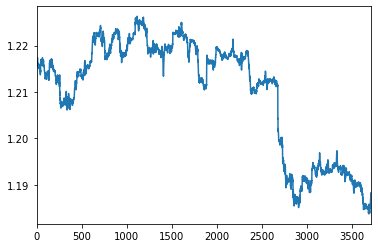

In [193]:
data.close.plot()

In [194]:
def BBANDS(df, n):
    MA= pd.Series(pd.Series.rolling(df['close'], n).mean())
    MSD=pd.Series(pd.Series.rolling(df['close'], n).std())
    b1=MA + (MSD*2)
    B1= pd.Series(b1, name = 'BollingerSuperior')
    df= df.join(B1)
    b2= MA - (MSD*2)
    B2= pd.Series(b2, name = 'BollingerInferior')
    df = df.join(B2)
    b3= MA
    B3= pd.Series(b3, name = 'BollingerM_')
    df = df.join(B3)
    return df

In [195]:
df = BBANDS(data,2)
df

time     open     high      low    close  tick_volume  \
0    2021-05-09 19:00:00  1.21599  1.21707  1.21599  1.21659          546   
1    2021-05-09 19:15:00  1.21659  1.21667  1.21654  1.21663          379   
2    2021-05-09 19:30:00  1.21663  1.21663  1.21654  1.21657          278   
3    2021-05-09 19:45:00  1.21657  1.21663  1.21613  1.21661          370   
4    2021-05-09 20:00:00  1.21661  1.21728  1.21653  1.21725         3970   
5    2021-05-09 20:15:00  1.21725  1.21740  1.21627  1.21627         3302   
6    2021-05-09 20:30:00  1.21627  1.21639  1.21606  1.21628         2949   
7    2021-05-09 20:45:00  1.21628  1.21669  1.21626  1.21668         1794   
8    2021-05-09 21:00:00  1.21668  1.21724  1.21668  1.21714         3322   
9    2021-05-09 21:15:00  1.21714  1.21728  1.21698  1.21718         2660   
10   2021-05-09 21:30:00  1.21718  1.21744  1.21705  1.21738         3133   
11   2021-05-09 21:45:00  1.21737  1.21761  1.21699  1.21699         4468   
12   2021-05-09 22:00:00  1.21699  1.21700  1.21622  1.21652         8702   
13   2021-05-09 22:15:00  1.21652  1.21672  1.21606  1.21625         7208   
14   2021-05-09 22:30:00  1.21625  1.21645  1.21592  1.21605         6614   
15   2021-05-09 22:45:00  1.21606  1.21635  1.21594  1.21608         7308   
16   2021-05-09 23:00:00  1.21608  1.21625  1.21584  1.21622         9051   
17   2021-05-09 23:15:00  1.21622  1.21624  1.21552  1.21562         8973   
18   2021-05-09 23:30:00  1.21562  1.21583  1.21538  1.21583         8795   
19   2021-05-09 23:45:00  1.21583  1.21592  1.21552  1.21574         7303   
20   2021-05-10 00:00:00  1.21574  1.21602  1.21573  1.21574         6977   
21   2021-05-10 00:15:00  1.21574  1.21577  1.21523  1.21527         6962   
22   2021-05-10 00:30:00  1.21527  1.21552  1.21523  1.21539         6432   
23   2021-05-10 00:45:00  1.21539  1.21541  1.21506  1.21508         6085   
24   2021-05-10 01:00:00  1.21508  1.21523  1.21504  1.21516         5277   
25   2021-05-10 01:15:00  1.21516  1.21554  1.21514  1.21552         5551   
26   2021-05-10 01:30:00  1.21552  1.21558  1.21543  1.21546         5540   
27   2021-05-10 01:45:00  1.21546  1.21546  1.21532  1.21541         4065   
28   2021-05-10 02:00:00  1.21541  1.21552  1.21525  1.21544         4451   
29   2021-05-10 02:15:00  1.21544  1.21556  1.21534  1.21546         3640   
30   2021-05-10 02:30:00  1.21546  1.21560  1.21540  1.21554         3857   
31   2021-05-10 02:45:00  1.21554  1.21566  1.21507  1.21508         5016   
32   2021-05-10 03:00:00  1.21508  1.21564  1.21508  1.21563         5229   
33   2021-05-10 03:15:00  1.21563  1.21568  1.21531  1.21556         5175   
34   2021-05-10 03:30:00  1.21556  1.21587  1.21544  1.21556         6381   
35   2021-05-10 03:45:00  1.21556  1.21558  1.21498  1.21510         7094   
36   2021-05-10 04:00:00  1.21510  1.21564  1.21506  1.21562         9271   
37   2021-05-10 04:15:00  1.21562  1.21591  1.21551  1.21559         9122   
38   2021-05-10 04:30:00  1.21559  1.21607  1.21514  1.21603        10079   
39   2021-05-10 04:45:00  1.21603  1.21624  1.21570  1.21599         9518   
40   2021-05-10 05:00:00  1.21599  1.21604  1.21448  1.21464        12497   
41   2021-05-10 05:15:00  1.21464  1.21503  1.21448  1.21482        10552   
42   2021-05-10 05:30:00  1.21482  1.21487  1.21360  1.21371        10522   
43   2021-05-10 05:45:00  1.21371  1.21481  1.21365  1.21474        10389   
44   2021-05-10 06:00:00  1.21474  1.21481  1.21392  1.21429        10454   
45   2021-05-10 06:15:00  1.21429  1.21587  1.21420  1.21582         9940   
46   2021-05-10 06:30:00  1.21582  1.21688  1.21562  1.21686        10962   
47   2021-05-10 06:45:00  1.21686  1.21745  1.21673  1.21703        10677   
48   2021-05-10 07:00:00  1.21703  1.21703  1.21599  1.21603         9108   
49   2021-05-10 07:15:00  1.21603  1.21632  1.21565  1.21603         8672   
50   2021-05-10 07:30:00  1.21603  1.21627  1.21571  1.21619         8766   
51   2021-05-10 

In [199]:
df2 = df[['close','BollingerSuperior','BollingerInferior','BollingerM_']]
df3=df2.drop(0,axis=0)
df3.tail(),df3.head()

(        close  BollingerSuperior  BollingerInferior  BollingerM_
 3709  1.18762           1.188826           1.187044     1.187935
 3710  1.18761           1.187629           1.187601     1.187615
 3711  1.18776           1.187897           1.187473     1.187685
 3712  1.18703           1.188427           1.186363     1.187395
 3713  1.18696           1.187094           1.186896     1.186995,
      close  BollingerSuperior  BollingerInferior  BollingerM_
 1  1.21663           1.216667           1.216553      1.21661
 2  1.21657           1.216685           1.216515      1.21660
 3  1.21661           1.216647           1.216533      1.21659
 4  1.21725           1.217835           1.216025      1.21693
 5  1.21627           1.218146           1.215374      1.21676)

In [208]:
close=df3['close']
BI=df3['BollingerInferior']
BS=df3['BollingerSuperior']

In [209]:
def Estrategia_BB(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal
X = Estrategia_BB(close,BI,BS)

KeyError: -1

In [180]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(5):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
position

[1, 1, 0, 1, 0]

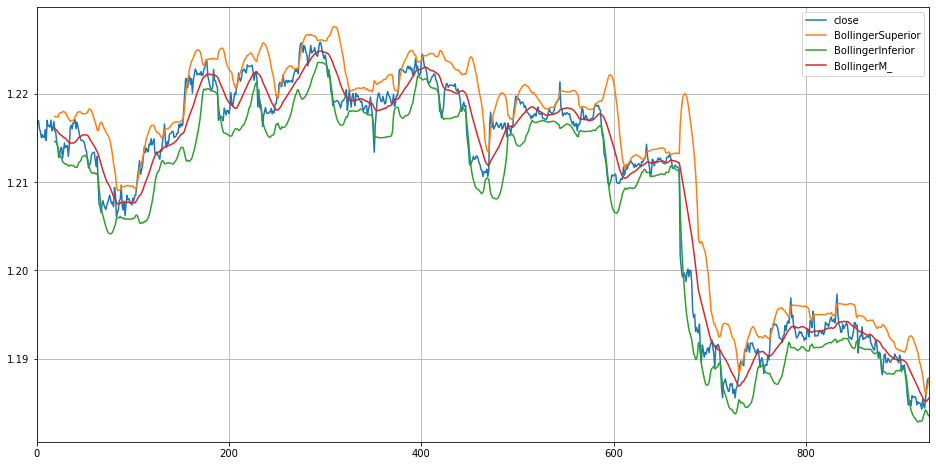

In [27]:
df2.plot(figsize = (16,8),grid=True)

In [28]:
a = df['BollingerSuperior']
b = df['BollingerInferior']

data.loc[(data['close'] < a) & (data['close'] > b), 'Comportamiento'] = 'Entre bandas'
data.loc[data['close'] <b, 'Comportamiento'] = 'Cruce de banda inferior'
data.loc[data['close'] >a, 'Comportamiento'] = 'Cruce de banda superior'

data.loc[(data['close'] < a) & (data['close'] > b), 'Recomendacion'] = '-'
data.loc[data['close'] <b, 'Recomendacion'] = 'Se recomienda comprar la accion.'
data.loc[data['close'] >a, 'Recomendacion'] = 'Se recomienda vender la accion'

data["Recomendacion"] = data["Recomendacion"].fillna("-")
data["Comportamiento"] = data["Comportamiento"].fillna("Sin informacion")

In [29]:
pd.set_option('display.max_rows', None)

In [30]:
data[['close','Comportamiento', 'Recomendacion']]

close           Comportamiento                     Recomendacion
0    1.21661          Sin informacion                                 -
1    1.21668          Sin informacion                                 -
2    1.21699          Sin informacion                                 -
3    1.21608          Sin informacion                                 -
4    1.21574          Sin informacion                                 -
5    1.21508          Sin informacion                                 -
6    1.21541          Sin informacion                                 -
7    1.21508          Sin informacion                                 -
8    1.21510          Sin informacion                                 -
9    1.21599          Sin informacion                                 -
10   1.21474          Sin informacion                                 -
11   1.21703          Sin informacion                                 -
12   1.21637          Sin informacion                                 -
13   1.21637          Sin informacion                                 -
14   1.21627          Sin informacion                                 -
15   1.21705          Sin informacion                                 -
16   1.21584          Sin informacion                                 -
17   1.21604          Sin informacion                                 -
18   1.21690          Sin informacion                                 -
19   1.21583             Entre bandas                                 -
20   1.21561             Entre bandas                                 -
21   1.21446             Entre bandas                                 -
22   1.21404  Cruce de banda inferior  Se recomienda comprar la accion.
23   1.21282  Cruce de banda inferior  Se recomienda comprar la accion.
24   1.21301  Cruce de banda inferior  Se recomienda comprar la accion.
25   1.21386             Entre bandas                                 -
26   1.21397             Entre bandas                                 -
27   1.21271             Entre bandas                                 -
28   1.21361             Entre bandas                                 -
29   1.21445             Entre bandas                                 -
30   1.21391             Entre bandas                                 -
31   1.21408             Entre bandas                                 -
32   1.21417             Entre bandas                                 -
33   1.21295             Entre bandas                                 -
34   1.21406             Entre bandas                                 -
35   1.21617             Entre bandas                                 -
36   1.21648             Entre bandas                                 -
37   1.21606             Entre bandas                                 -
38   1.21676             Entre bandas                                 -
39   1.21675             Entre bandas                                 -
40   1.21709             Entre bandas                                 -
41   1.21607             Entre bandas                                 -
42   1.21683             Entre bandas                                 -
43   1.21631             Entre bandas                                 -
44   1.21576             Entre bandas                                 -
45   1.21520             Entre bandas                                 -
46   1.21480             Entre bandas                                 -
47   1.21473             Entre bandas                                 -
48   1.21475             Entre bandas                                 -
49   1.21462             Entre bandas                                 -
50   1.21434             Entre bandas                                 -
51   1.21374             Entre bandas                                 -
52   1.21344             Entre bandas                                 -
53   1.21239  Cruce de banda inferior  Se recomienda comprar la accion.
54   1.21163  Cruce de banda inferior  Se recom

In [48]:
def STO(df, nK, nD, nS=1):
    SOk = pd.Series((df['close'] - df['low'].rolling(nK).min())/(df['high'].rolling(nK).max() - df['low'].rolling(nK).min()), name = 'SOk'+str(nK) )
    SOd = pd.Series(SOk.ewm(ignore_na = False, span = nD, min_periods = nD -1, adjust = True).mean(), name = 'SOd'+str(nD))
    SOk = SOk.ewm(ignore_na = False, span = nS, min_periods = nS - 1 , adjust = True).mean()
    SOd = SOd.ewm(ignore_na = False, span = nS, min_periods = nS - 1 , adjust = True).mean()
    df = df.join(SOk)
    df = df.join(SOd)
    df['Recomendacion'] = 0
    df.loc[(((SOk < SOd) & (SOk.shift(1) > SOd.shift(1))) & (SOd > 0.8)),'Recomendacion'] = 'Vender'
    df.loc[(((SOk > SOd) & (SOk.shift(1) < SOd.shift(1))) & (SOd < 0.2)),'Recomendacion'] = 'Comprar'
    df.loc[ df['Recomendacion'] == 0, 'Recomendacion'] = '-'

    return df

In [49]:
df2 = STO(data, 14, 3)

In [50]:
import matplotlib.pyplot as plt

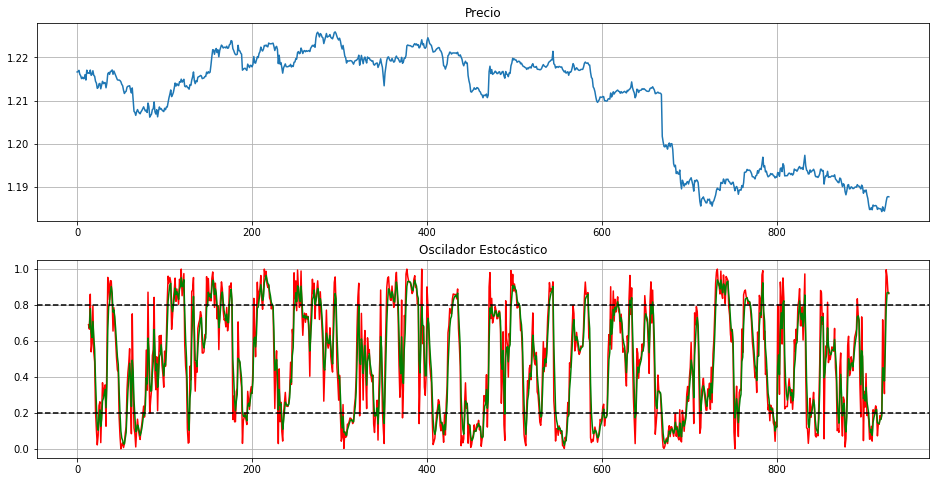

In [51]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(211)
plt.plot(df2.close)
plt.grid(True)
plt.title('Precio')
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(df2.SOk14, color = 'r')
plt.plot(df2.SOd3, color = 'g')
plt.axhline(y=0.8, color = 'k', linestyle = '--')
plt.axhline(y=0.2, color = 'k', linestyle = '--')
plt.title('Oscilador Estocástico')
plt.grid(True)
plt.show()

In [52]:
df2[['close', 'Recomendacion']]

close Recomendacion
0    1.21661             -
1    1.21668             -
2    1.21699             -
3    1.21608             -
4    1.21574             -
5    1.21508             -
6    1.21541             -
7    1.21508             -
8    1.21510             -
9    1.21599             -
10   1.21474             -
11   1.21703             -
12   1.21637             -
13   1.21637             -
14   1.21627             -
15   1.21705             -
16   1.21584             -
17   1.21604             -
18   1.21690             -
19   1.21583             -
20   1.21561             -
21   1.21446             -
22   1.21404             -
23   1.21282             -
24   1.21301             -
25   1.21386       Comprar
26   1.21397             -
27   1.21271             -
28   1.21361       Comprar
29   1.21445             -
30   1.21391             -
31   1.21408             -
32   1.21417             -
33   1.21295             -
34   1.21406             -
35   1.21617             -
36   1.21648             -
37   1.21606             -
38   1.21676             -
39   1.21675             -
40   1.21709        Vender
41   1.21607             -
42   1.21683             -
43   1.21631             -
44   1.21576             -
45   1.21520             -
46   1.21480             -
47   1.21473             -
48   1.21475             -
49   1.21462             -
50   1.21434             -
51   1.21374             -
52   1.21344             -
53   1.21239             -
54   1.21163       Comprar
55   1.21196             -
56   1.21215             -
57   1.21309             -
58   1.21330             -
59   1.21336             -
60   1.21342             -
61   1.21251             -
62   1.21176             -
63   1.21292             -
64   1.21003             -
65   1.20750             -
66   1.20724             -
67   1.20657             -
68   1.20741       Comprar
69   1.20791             -
70   1.20743             -
71   1.20712             -
72   1.20693             -
73   1.20739       Comprar
74   1.20769             -
75   1.20812             -
76   1.20854             -
77   1.20801             -
78   1.20757             -
79   1.20776             -
80   1.20724             -
81   1.20942             -
82   1.20858             -
83   1.20615             -
84   1.20654             -
85   1.20685             -
86   1.20791             -
87   1.20808             -
88   1.20968             -
89   1.20735             -
90   1.20687             -
91   1.20787             -
92   1.20623             -
93   1.20753             -
94   1.20851             -
95   1.20803             -
96   1.20814             -
97   1.20780             -
98   1.20760             -
99   1.20744             -
100  1.20820             -
101  1.20788             -
102  1.20847             -
103  1.20850             -
104  1.20956             -
105  1.21065             -
106  1.21146             -
107  1.21245             -
108  1.21091             -
109  1.21131             -
110  1.21187             -
111  1.21287             -
112  1.21405             -
113  1.21335        Vender
114  1.21390             -
115  1.21362        Vender
116  1.21345             -
117  1.21433             -
118  1.21425             -
119  1.21495             -
120  1.21425        Vender
121  1.21453             -
122  1.21492             -
123  1.21332             -
124  1.21318             -
125  1.21343             -
126  1.21309             -
127  1.21290             -
128  1.21263             -
129  1.21369             -
130  1.21350             -
131  1.21473             -
132  1.21547             -
133  1.21661             -
134  1.21459             -
135  1.21391             -
136  1.21460             -
137  1.21436             -
138  1.21540             -
139  1.21552             -
140  1.21560             -
141  1.21580             -
142  1.21571             -
143  1.21507             -
144  1.21516             -
145  1.21523             -
146  1.21556             -
147  1.2155